# Introduction 2:
## Visualization in jupyter notebook


### Reading in the data:
- We use xarray here, but you can also use e.g. iris or even pyaerocom!
- We recomend however, that you use a package that keeps track of your coordinates in your data and the metadata in your data! (E.g. numpy doesn't do this) 
- This is also why the NetCDF format is so popular -- it keeps track of these things and is extremely easy to load with these packages. 


In [52]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# or
# from imports import (plt, np, xr)
path='../../data_sample/wrf_out.small.h5'
ds = xr.open_dataset(path)#, decode_times=False)

Check how your dataset looks

In [53]:
#lets check how the dataset looks like
ds

<xarray.Dataset>
Dimensions:  (XTIME: 1449, bottom_top: 10, south_north: 17, west_east: 23)
Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
  * XTIME    (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    P        (XTIME, bottom_top, south_north, west_east) float32 ...
    V        (XTIME, bottom_top, south_north, west_east) float32 ...
    U        (XTIME, bottom_top, south_north, west_east) float32 ...
    T        (XTIME, bottom_top, south_north, west_east) float32 ...

**Check the attributes! Can be useful info here:**

In [54]:
ds['XTIME']

<xarray.DataArray 'XTIME' (XTIME: 1449)>
array(['2017-12-02T00:00:00.000000000', '2017-12-02T03:00:00.000000000',
       '2017-12-02T06:00:00.000000000', ..., '2018-05-31T18:00:00.000000000',
       '2018-05-31T21:00:00.000000000', '2018-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
Attributes:
    FieldType:    104
    MemoryOrder:  0  
    description:  minutes since 2017-12-02 00:00:00
    stagger:      

**Assign attributes!** Nice for plotting and to keep track of what is in your dataset (especially 'units' and 'standard_name'/'long_name' will be looked for by xarray.

In [55]:
# lets process potential temperature into C
ds['T_C'] = ds['T'] + 300 - 273
ds['T_C'] = ds['T_C'].assign_attrs({'units': 'C'})

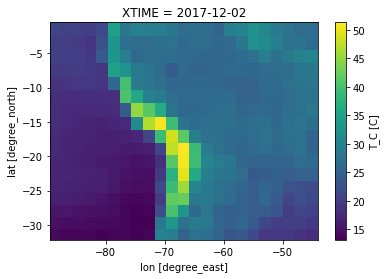

In [62]:
# lets do a basic plot of T_C
ds[T_C].isel(XTIME=0,bottom_top=0).plot()
# analogy:
#ds[T_C][{ilev:0,time:0}].plot()

The coordinate 'south_north' annoyes me, so I change it!

In [57]:
# Initially just a number, I want the actual latitude!
ds['south_north'] = ds.XLAT[:,0]
ds['west_east']=ds.XLONG[0,:]
# Rename them!
ds=ds.rename({'south_north':'lat','west_east':'lon'})

In [ ]:
## from zarray import : 

Easier to type if we define some names:

In [45]:
#lets define some constants for the variable names so that calling them is easier.
ilev = 'bottom_top'
lat = 'lat'
lon = 'lon'
XT  = 'XTIME'
time = 'XTIME'
lat = 'XLAT'
lon = 'XLONG'
P, V, U, T = 'P','V','U','T'

#this is potential temperature in C
T_C = 'T_C'

## Plotting

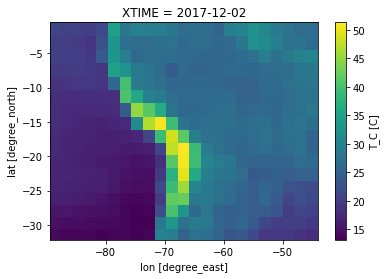

In [62]:
# lets do a basic plot of T_C
ds[T_C].isel(XTIME=0,bottom_top=0).plot()
# analogy:
#ds[T_C][{ilev:0,time:0}].plot()

### Make new variables:

In [67]:
WS = 'Wind strength'
ds[WS] = np.sqrt(ds[U]**2+ ds[V]**2)
ds[WS].attrs['units']='m/s'
ds[WS].attrs['name']='Wind strength'

## Use cartopy

In [64]:
import cartopy as cy

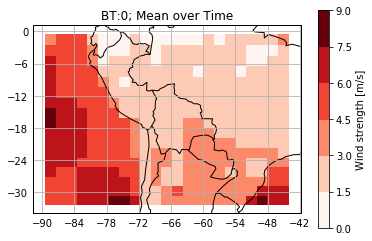

In [75]:
f,ax = plt.subplots(subplot_kw={'projection':cy.crs.PlateCarree()})
_ds = ds[{ilev:0}]
_dm = _ds[WS].mean(time, keep_attrs=True)
_dm.plot.pcolormesh(cmap = plt.get_cmap('Reds'),ax=ax,
    transform=cy.crs.PlateCarree(),
    levels = 6
)
ax.set_title('BT:0; Mean over Time')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
ax.add_feature(cy.feature.BORDERS);

### Quick statistics:

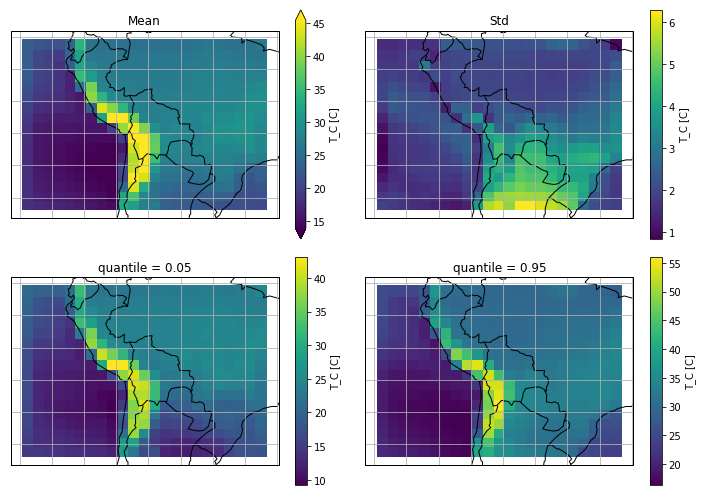

In [80]:
import cartopy.crs as ccrs
import cartopy as cy
fig, axsm = plt.subplots(2,2, figsize=[10,7], subplot_kw={'projection':ccrs.PlateCarree()})
axs = axsm.flatten()
_ds = ds[T_C][{ilev:0}]
_ds.mean(time, keep_attrs=True).plot(ax=axs[0], 
                                     transform=ccrs.PlateCarree(), 
                                     robust=True)
axs[0].set_title('Mean')
_ds.std(time, keep_attrs=True).plot(ax=axs[1], 
                                    transform=ccrs.PlateCarree())#, robust=True)
axs[1].set_title('Std')
_ds.quantile(0.05, dim=time, keep_attrs=True).plot(ax=axs[2], 
                                                   transform=ccrs.PlateCarree())#, robust=True)
_ds.quantile(0.95, dim=time, keep_attrs=True).plot(ax=axs[3], 
                                                   transform=ccrs.PlateCarree())#, robust=True)
for ax in axs:
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl.xlabels_top = False
    gl.ylabels_right = False

plt.tight_layout()

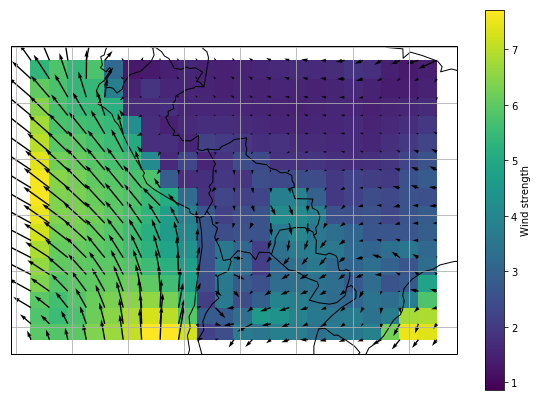

In [81]:
import cartopy.crs as ccrs
import cartopy as cy
fig, ax = plt.subplots(1, figsize=[10,7], subplot_kw={'projection':ccrs.PlateCarree()})

_ds = ds[[U,V, WS]][{ilev:0}].mean(XT) #keep_attrs=True)
_ds[WS].plot(x=lon, y=lat, transform=ccrs.PlateCarree())
ax.quiver(_ds[lon], _ds[lat], _ds['U'],_ds['V'], transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines()
ax.add_feature(cy.feature.BORDERS);
#plt.tight_layout()

### Tired of making plots:

In [82]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)

def add_map_features(ax):
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False




/home/sarambl/anaconda3/envs/general/lib/python3.6/site-packages/xarray/core/common.py:608: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


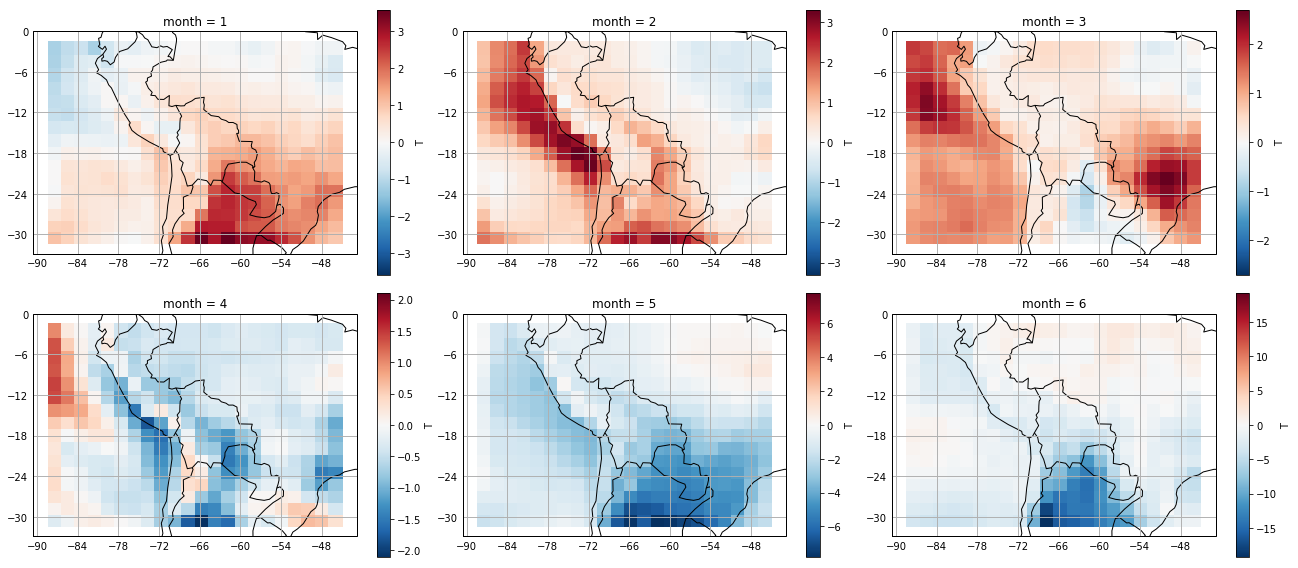

In [84]:
fig, axs = sp_map(2,3, figsize=[18,8], sharex=True, sharey=True)
# Use groupby! (doesn't need to be in time):
T_mm = ds[T][{ilev:0}].groupby('XTIME.month').mean(XT)
T_mean = ds[T][{ilev:0}].mean(XT)
# let's check the deviation from the mean over the whole period! (Easier to see)

# MARK: THIS WOULD NOT WORK IN NUMPY!
T_dev = T_mm- T_mean
for mo, ax in zip(T_mm['month'], axs.flatten()):
    T_dev.sel(month=mo).plot(x=lon, y=lat, ax=ax, transform=ccrs.PlateCarree())
    add_map_features(ax)
plt.tight_layout()

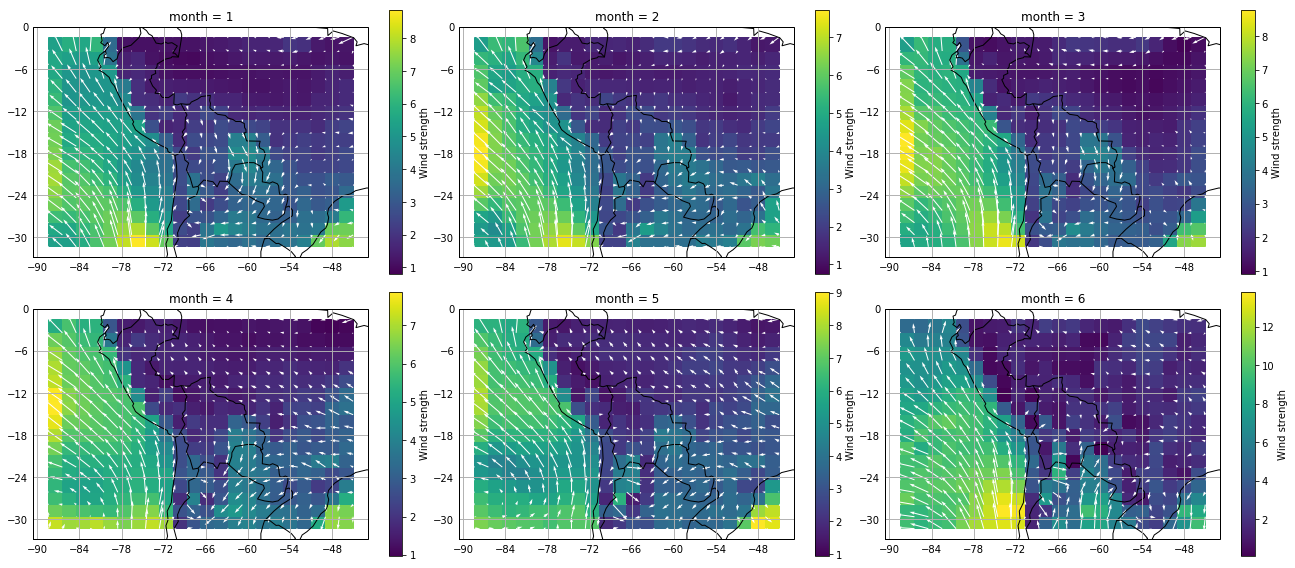

In [51]:
fig, axs = sp_map(2,3, figsize=[18,8])
# select bottom layer and group by month and apply mean:
W_mm = ds[{ilev:0}].groupby('XTIME.month').mean(XT)

for mo, ax in zip(T_mm['month'], axs.flatten()):
    _dsm = W_mm.sel(month=mo)
    _dsm[WS].plot(x=lon, y=lat, ax=ax, transform=ccrs.PlateCarree())
    ax.quiver(_dsm[lon], _dsm[lat], _dsm['U'], _dsm['V'], transform=ccrs.PlateCarree(), color='w')

    add_map_features(ax)
plt.tight_layout()

## Lev lat plot:

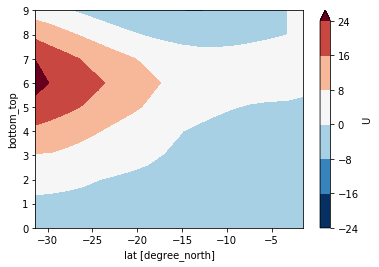

In [52]:
_ds = ds.copy()
_ds['south_north'] = ds[lat][:, 0]
_ds = _ds.rename({'south_north':'lat'})
_ds[U].mean([XT,'west_east']).plot.contourf(robust=True)

## Typical pandas methods often apply (or have an analogy): Daily max, daily min.
Google xarray and the name of your favorite function

In [85]:
ds_dmax = ds.resample(XTIME='1D').max()
ds_dmin = ds.resample(XTIME='1D').min()


In [46]:
ds_dmax

<xarray.Dataset>
Dimensions:        (XTIME: 182, bottom_top: 10, south_north: 17, west_east: 23)
Coordinates:
  * XTIME          (XTIME) datetime64[ns] 2017-12-02 2017-12-03 ... 2018-06-01
    XLAT           (south_north, west_east) float32 -31.348223 ... -1.4679687
    XLONG          (south_north, west_east) float32 -88.401634 ... -44.987724
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    P              (XTIME, bottom_top, south_north, west_east) float32 2622.2117 ... 0.08257812
    V              (XTIME, bottom_top, south_north, west_east) float32 7.277119 ... 0.3874269
    U              (XTIME, bottom_top, south_north, west_east) float32 -3.5968585 ... 0.5220239
    T              (XTIME, bottom_top, south_north, west_east) float32 -12.887212 ... 133.33698
    T_C            (XTIME, bottom_top, south_north, west_east) float32 14.112793 ... 160.33698
    Wind strength  (XTIME, bottom_top, south_north, west_east) float32 8.117503 ... 0.65008354

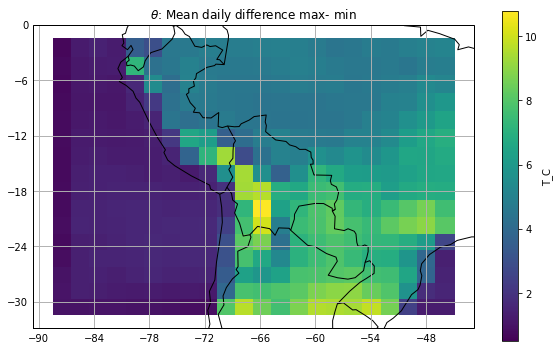

In [87]:
fig, ax = sp_map(1, figsize = [8,5])
ds_diffmm = ds_dmax -ds_dmin
_diff = ds_diffmm[{ilev:0}].mean(time)
kwargs = { 'transform':ccrs.PlateCarree()}
_diff[T_C].plot(x=lon, y=lat, ax=ax, **kwargs)
ax.set_title(r'$\theta$: Mean daily difference max- min')
add_map_features(ax)
plt.tight_layout()

## Check a particular place (e.g. to compare to observations)
Chacaltaya measuring station is located at roughly (-16.34, -68.12). We will pick out the grid cell closest to this. 

In [88]:
CHC =      {'lat' : -16.34, 'lon' : -68.12}
#marine =   {'lat' : -16.44, 'lon' : -72.24}
#amazonas = {'lat' : -5.08,  'lon' : -64.44}

In [90]:
ds_chc = ds.sel(lat=CHC['lat'], lon=CHC['lon'], method='nearest')

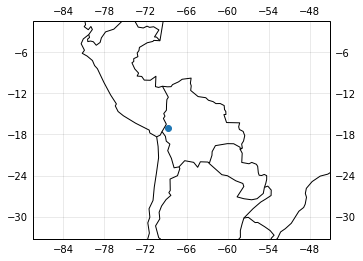

In [93]:
ax = plt.axes(projection=cy.crs.PlateCarree())
ax.set_extent([ds[lon].min(),
               ds[lon].max(),
               ds[lat].min(),
               ds[lat].max()
              ])
ax.scatter(ds_chc[lon],ds_chc[lat])
ax.coastlines()
ax.add_feature(cy.feature.BORDERS);
gl = ax.gridlines(draw_labels=True,color='k',alpha=.1)

In [95]:
_df = ds_chc.to_dataframe()

In [96]:
f = bok.figure_dt()
f.line(source=_df,x='XTIME',y='T')
f.plot_height = 200
bok.show(f)

NameError: name 'bok' is not defined

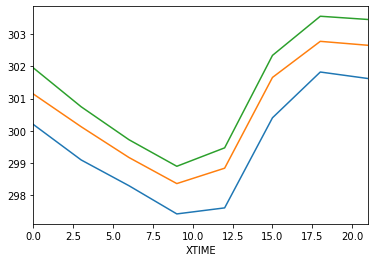

In [26]:
f, ax = plt.subplots()
_group = _df['T'].groupby(_df.index.hour)
qs = [.25,.5,.75]
for q in qs:
    _group.quantile(q).plot(ax=ax, label=q)

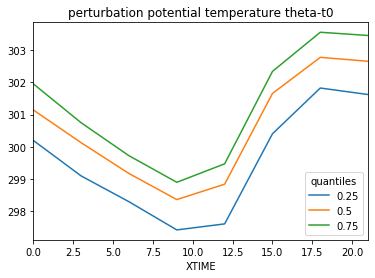

In [27]:
ax.set_title(ds['T'].description)
ax.legend(title='quantiles')
ax.figure

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
_df['secs']=_df.index.astype('int')/1e9

In [30]:
model = LinearRegression()

In [31]:
x = _df['secs'].values.reshape(-1,1)
y = _df['T'   ].values.reshape(-1,1)

In [32]:
model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
_df['x_predict']=model.predict(x).flatten()

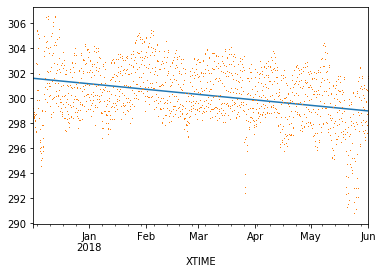

In [34]:
_df['x_predict'].plot()
_df['T'].plot(marker=',',linewidth=0)

In [33]:
locations={'CHC':CHC, 'marine':marine, 'amazonas':amazonas}

In [34]:
ds2 = ds.copy()
ds2['south_north'] = ds2.XLAT[:,0]
ds2['west_east']=ds2.XLONG[0,:]
ds2=ds2.rename({'south_north':'lat','west_east':'lon'})

In [ ]:
ds

In [28]:
li=[]
for loc in locations:
    slat = locations[loc]['lat']
    slon = locations[loc]['lon']
    ds_loc = ds2.sel(lat=slat, 
                     lon=slon , 
                     method='nearest')
    li.append(ds_loc)

In [24]:
ds_loc= xr.concat(li, dim='location')#{'LOC':list(locations.keys())})
ds_loc['location']=list(locations.keys())
ds_loc

<xarray.Dataset>
Dimensions:        (XTIME: 1449, bottom_top: 10, location: 3)
Coordinates:
  * XTIME          (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
    XLAT           (location) float32 -16.999245 -16.999245 -5.406621
    XLONG          (location) float32 -44.987724 -72.61475 -64.72132
    lat            (location) float32 -16.999245 -16.999245 -5.406621
    lon            (location) float32 -44.987724 -72.61475 -64.72132
  * location       (location) <U8 'CHC' 'marine' 'amazonas'
Dimensions without coordinates: bottom_top
Data variables:
    P              (location, XTIME, bottom_top) float32 1229.8431 ... 0.76904297
    V              (location, XTIME, bottom_top) float32 -3.0193253 ... 0.3143518
    U              (location, XTIME, bottom_top) float32 -2.2556481 ... 5.128983
    T              (location, XTIME, bottom_top) float32 -1.541383 ... 138.19656
    T_C            (location, XTIME, bottom_top) float32 25.458618 ... 165.19656
    Wind strength  (location, XTIME,

/home/sarambl/anaconda3/envs/general/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


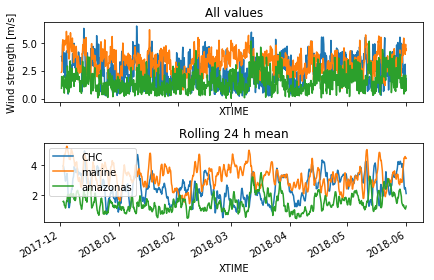

In [25]:
fig, axs = plt.subplots(2,1, sharex=True)
for loc in ds_loc.location.values:
    ds_loc[{ilev:0}]['Wind strength'].sel(location=loc).plot(label=loc, ax=axs[0])
    axs[0].set_title('All values')
    ds_loc[{ilev:0}]['Wind strength'].sel(location=loc).rolling(XTIME=8).mean().plot(label=loc, ax=axs[1])
    axs[1].set_title('Rolling 24 h mean')

axs[1].legend()
plt.tight_layout()

## Convert to pandas:

In [26]:
df_loc = ds_loc[{ilev:0}].to_dataframe()

In [27]:
df_loc

P         V         U         T  \
XTIME               location                                              
2017-12-02 00:00:00 CHC       1229.843140 -3.019325 -2.255648 -1.541383   
                    marine    1399.709106  2.016470 -1.227415 -5.899125   
                    amazonas   613.381592  0.821042 -0.427001 -0.980686   
2017-12-02 03:00:00 CHC       1167.614380 -2.977887 -2.286594 -1.595747   
                    marine    1316.254395  1.619147 -1.793550 -6.657432   
...                                   ...       ...       ...       ...   
2018-05-31 21:00:00 marine    1254.000977  3.208141 -2.824981 -9.469061   
                    amazonas  1065.756226  0.457274 -0.534182  1.111743   
2018-06-01 00:00:00 CHC       1620.141602  0.879737 -1.560841 -0.933029   
                    marine    1253.637451  3.275094 -2.987550 -9.736329   
                    amazonas  1098.147217  0.734984 -1.417634 -0.264313   

                                   XLAT      XLONG        T_C  Wind strength  \
XTIME               location                                                   
2017-12-02 00:00:00 CHC      -16.999245 -44.987724  25.458618       3.768856   
                    marine   -16.999245 -72.614754  21.100861       2.360656   
                    amazonas  -5.406621 -64.721321  26.019318       0.925441   
2017-12-02 03:00:00 CHC      -16.999245 -44.987724  25.404266       3.754507   
                    marine   -16.999245 -72.614754  20.342560       2.416291   
...                                 ...        ...        ...            ...   
2018-05-31 21:00:00 marine   -16.999245 -72.614754  17.530945       4.274656   
                    amazonas  -5.406621 -64.721321  28.111755       0.703171   
2018-06-01 00:00:00 CHC      -16.999245 -44.987724  26.066986       1.791692   
                    marine   -16.999245 -72.614754  17.263672       4.433023   
                    amazonas  -5.406621 -64.721321  26.735687       1.596836   

                                    lat        lon  
XTIME               location                        
2017-12-02 00:00:00 CHC      -16.999245 -44.987724  
                    marine   -16.999245 -72.614754  
                    amazonas  -5.406621 -64.721321  
2017-12-02 03:00:00 CHC      -16.999245 -44.987724  
                    marine   -16.999245 -72.614754  
...                                 ...        ...  
2018-05-31 21:00:00 marine   -16.999245 -72.614754  
                    amazonas  -5.406621 -64.721321  
2018-06-01 00:00:00 CHC      -16.999245 -44.987724  
                    marine   -16.999245 -72.614754  
                    amazonas  -5.406621 -64.721321  

[4347 rows x 10 columns]